# Comparing different built in models with the available data

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import os
from PIL import Image
import torchvision.models.video as video_models
import torch.nn as nn
import tqdm

### import custom dataset

In [2]:
import video_dataset as Dataset

raw_path = '../data/WLASL2000'
instances_path = './preprocessed_labels/asl100/train_instances_fixed_bboxes_short.json'
classes_path = './wlasl_class_list.json'
train_set = Dataset.VideoDataset(
  root=raw_path,
  instances_path=instances_path,
  classes_path=classes_path,
  transform=Dataset.min_transform_rI3d
)


print(f"Length: {len(train_set)}")

Length: 1442


### Setup dataloader

In [3]:
torch.manual_seed(42)
train_loader = DataLoader(
  train_set,
  batch_size=2,
  shuffle=True,
  num_workers=0 #to use manual seed
)
train_loader

## 3D CNNs

### r3d_18

There may be some issues with memory...

### Initialisation:

In [4]:
#load pretrained mode
model = video_models.r3d_18(pretrained=True)

#alter classifier
num_classes = 100
model.fc = nn.Linear(model.fc.in_features, num_classes)

/home/luke/ExtraStorage/WLASL/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/luke/ExtraStorage/WLASL/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Training setup:

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

model = model.to(device)

for param in model.parameters():
  param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
  

Device: cuda


In [6]:
def train_model(model, data_loader, optimizer, loss_func, epochs=10,val_loader=None):
  model.train()
    
  for epoch in tqdm.tqdm(range(epochs), desc="Training R3D"):
    running_loss = 0.0
      
    for batch_idx, (data, target) in enumerate(data_loader):
      # data shape: (batch_size, 3, frames, height, width)
      data, target = data.to(device), target.to(device)
      
      optimizer.zero_grad()
      output = model(data)
      loss = loss_func(output, target)
      loss.backward()
      optimizer.step()
      
      running_loss += loss.item()
      
      # if batch_idx % 100 == 0:
      #     print(f'Epoch [{epoch+1}/{epochs}], Step [{batch_idx}], Loss: {loss.item():.4f}')
      
    print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {running_loss/len(data_loader):.4f}')

In [7]:
train_model(model=model, data_loader=train_loader, optimizer=optimizer, loss_func=loss_func)

Training R3D:   0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: GET was unable to find an engine to execute this computation

### Output from nvidia-smi:

NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     Off |   00000000:01:00.0  On |                  N/A |
| 53%   72C    P2            288W /  300W |    4448MiB /  11264MiB |    100%      Default |
|                                         |                        |                  N/A |

can probably stand to increase batch size


### Increased batch size to 2:

 NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     Off |   00000000:01:00.0  On |                  N/A |
| 42%   67C    P2            303W /  300W |   10054MiB /  11264MiB |    100%      Default |
|                                         |                        |                  N/A |


### the loss seems to be decreasing, but lets see if we can do better plotting 

In [ ]:
# !pip install tensorboard
from torch.utils.tensorboard import SummaryWriter
import os

In [ ]:

def train_model_2(model, train_loader, optimizer, loss_func, epochs=10,val_loader=None,
                  output='runs/exp_0', logs='logs', save='checkpoints', save_every=1):
  if os.path.exists(output) and output[-1].isdigit():
    output = output[:-1] + str(int(output[-1])+ 1) #enumerate file name
  save_path=''
  if save:
    save_path = os.path.join(output, save)
    os.makedirs(save_path,exist_ok=True)
    
  logs_path = os.path.join(output, logs)
  writer = SummaryWriter(logs_path) #watching loss
  train_losses = []
  val_losses = []
  best_val_loss = float('inf')
  avg_val_loss = None
  model.train()
  for epoch in tqdm.tqdm(range(epochs), desc="Training R3D"):
    #Training phase
    running_loss = 0.0
    train_samples = 0
    
    for data, target in train_loader:
      data, target = data.to(device), target.to(device)
      
      optimizer.zero_grad()
      model_output = model(data)
      loss = loss_func(model_output, target)
      loss.backward()
      optimizer.step()
      
      running_loss += loss.item() * data.size(0) #weight by batch size
      train_samples += data.size(0)
      
    avg_train_loss = running_loss / train_samples
    train_losses.append(avg_train_loss)
    writer.add_scalar('Loss/Train', avg_train_loss, epoch)
    #Validation phase
    if val_loader:
      model.eval()
      val_loss = 0.0
      val_samples = 0
      
      with torch.no_grad():
        for data, target in val_loader:
          data, target = data.to(device), target.to(device)
          
          model_output = model(data)
          loss = loss_func(model_output, target)
          
          val_loss += loss.item() * data.size(0) #weight by batch size
          val_samples += data.size(0)
          
      avg_val_loss = val_loss / val_samples
      val_losses.append(avg_val_loss)
      writer.add_scalar('Loss/Val', avg_val_loss, epoch)
      
      if save and avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(),
                   os.path.join(save_path, 'best.pth'))
      
      print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
      model.train() # return back to train
    else:
      print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_train_loss:.4f}')
    
    if save and epoch % save_every == 0:
      avg_train_loss = avg_train_loss if avg_train_loss else 'N/A'
      avg_val_loss = avg_val_loss if avg_val_loss else 'N/A'
      torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train loss': avg_train_loss,
        'val loss': avg_val_loss,
        'train losses': train_losses,
        'val losses': val_losses
        }, os.path.join(save_path, f'checkpoint_{epoch}.pth'))
    
  return train_losses, val_losses

setup validation loader

In [ ]:
instances_path = './preprocessed_labels/asl100/val_instances_fixed_bboxes_short.json'
val_set = Dataset.VideoDataset(
  root=raw_path,
  instances_path=instances_path,
  classes_path=classes_path,
  transform=Dataset.min_transform_rI3d
)
val_loader = DataLoader(
  val_set,
  batch_size=2,
  shuffle=True,
  num_workers=0 #to use manual seed
)
val_loader

In [ ]:
train_losses, val_losses = train_model_2(
  model=model,
  train_loader=train_loader,
  optimizer=optimizer,
  loss_func=loss_func,
  epochs=100,
  val_loader=val_loader,
  output='runs/r3d18_exp1'
)

Training R3D:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 4.5985, Val Loss: 20.7178


Training R3D:   1%|          | 1/100 [19:02<31:25:12, 1142.56s/it]

Epoch [2/100], Train Loss: 4.5975, Val Loss: 8.6025


Training R3D:   2%|▏         | 2/100 [37:42<30:44:40, 1129.40s/it]

Epoch [3/100], Train Loss: 4.6120, Val Loss: 4.8030


Training R3D:   3%|▎         | 3/100 [56:06<30:06:55, 1117.68s/it]

Epoch [4/100], Train Loss: 4.6006, Val Loss: 6.2450


Training R3D:   4%|▍         | 4/100 [1:14:31<29:40:01, 1112.51s/it]

Epoch [5/100], Train Loss: 4.6050, Val Loss: 4.5992


Training R3D:   5%|▌         | 5/100 [1:32:53<29:15:45, 1108.90s/it]

Epoch [6/100], Train Loss: 4.6002, Val Loss: 5.0875


Training R3D:   6%|▌         | 6/100 [1:51:14<28:53:13, 1106.31s/it]

Epoch [7/100], Train Loss: 4.5993, Val Loss: 7.5098


Training R3D:   7%|▋         | 7/100 [2:09:35<28:31:56, 1104.47s/it]

Epoch [8/100], Train Loss: 4.5961, Val Loss: 4.7884


Training R3D:   8%|▊         | 8/100 [2:27:59<28:13:18, 1104.34s/it]

Epoch [9/100], Train Loss: 4.5997, Val Loss: 10.0440


Training R3D:   9%|▉         | 9/100 [2:46:27<27:56:46, 1105.56s/it]

Epoch [10/100], Train Loss: 4.5981, Val Loss: 9.2972


Training R3D:  10%|█         | 10/100 [3:04:55<27:39:12, 1106.14s/it]

Epoch [11/100], Train Loss: 4.5988, Val Loss: 10.0205


Training R3D:  11%|█         | 11/100 [3:23:22<27:21:22, 1106.55s/it]

Epoch [12/100], Train Loss: 4.5941, Val Loss: 9.8801


Training R3D:  12%|█▏        | 12/100 [3:41:51<27:03:45, 1107.11s/it]

Epoch [13/100], Train Loss: 4.5829, Val Loss: 7.3037


Training R3D:  13%|█▎        | 13/100 [4:00:17<26:44:55, 1106.84s/it]

Epoch [14/100], Train Loss: 4.5804, Val Loss: 16.8691


Training R3D:  14%|█▍        | 14/100 [4:18:53<26:30:35, 1109.71s/it]

Epoch [15/100], Train Loss: 4.5580, Val Loss: 11.1528


Training R3D:  15%|█▌        | 15/100 [4:37:46<26:21:45, 1116.53s/it]

Epoch [16/100], Train Loss: 4.5527, Val Loss: 6.7513


Training R3D:  16%|█▌        | 16/100 [4:56:23<26:03:38, 1116.89s/it]

Epoch [17/100], Train Loss: 4.5305, Val Loss: 7.1472


Training R3D:  17%|█▋        | 17/100 [5:14:45<25:38:39, 1112.28s/it]

Epoch [18/100], Train Loss: 4.5121, Val Loss: 8.1611


Training R3D:  18%|█▊        | 18/100 [5:33:08<25:16:20, 1109.51s/it]

Epoch [19/100], Train Loss: 4.4948, Val Loss: 32.2718


Training R3D:  19%|█▉        | 19/100 [5:51:24<24:52:26, 1105.51s/it]

Epoch [20/100], Train Loss: 4.4782, Val Loss: 6.9973


Training R3D:  20%|██        | 20/100 [6:09:40<24:30:14, 1102.68s/it]

Epoch [21/100], Train Loss: 4.4572, Val Loss: 7.3423


Training R3D:  21%|██        | 21/100 [6:27:56<24:09:12, 1100.66s/it]

Epoch [22/100], Train Loss: 4.4557, Val Loss: 9.9370


Training R3D:  22%|██▏       | 22/100 [6:46:12<23:49:01, 1099.25s/it]

Epoch [23/100], Train Loss: 4.4107, Val Loss: 8.8754


Training R3D:  23%|██▎       | 23/100 [7:04:28<23:29:15, 1098.12s/it]

Epoch [24/100], Train Loss: 4.4055, Val Loss: 6.5281


Training R3D:  24%|██▍       | 24/100 [7:22:42<23:09:28, 1096.95s/it]

Epoch [25/100], Train Loss: 4.4064, Val Loss: 6.8604


Training R3D:  25%|██▌       | 25/100 [7:40:55<22:49:51, 1095.89s/it]

Epoch [26/100], Train Loss: 4.3919, Val Loss: 12.5717


Training R3D:  26%|██▌       | 26/100 [7:59:09<22:30:56, 1095.36s/it]

Epoch [27/100], Train Loss: 4.3556, Val Loss: 8.1746


Training R3D:  27%|██▋       | 27/100 [8:17:23<22:12:05, 1094.87s/it]

Epoch [28/100], Train Loss: 4.3343, Val Loss: 7.9121


Training R3D:  28%|██▊       | 28/100 [8:35:37<21:53:20, 1094.45s/it]

Epoch [29/100], Train Loss: 4.3271, Val Loss: 9.5540


Training R3D:  29%|██▉       | 29/100 [8:53:50<21:34:49, 1094.23s/it]

Epoch [30/100], Train Loss: 4.2996, Val Loss: 8.0626


Training R3D:  30%|███       | 30/100 [9:12:04<21:16:20, 1094.01s/it]

Epoch [31/100], Train Loss: 4.2884, Val Loss: 8.4635


Training R3D:  31%|███       | 31/100 [9:30:17<20:57:56, 1093.86s/it]

Epoch [32/100], Train Loss: 4.2471, Val Loss: 6.2902


Training R3D:  32%|███▏      | 32/100 [9:48:30<20:39:28, 1093.66s/it]

Epoch [33/100], Train Loss: 4.2215, Val Loss: 8.0654


Training R3D:  33%|███▎      | 33/100 [10:06:44<20:21:09, 1093.57s/it]

Epoch [34/100], Train Loss: 4.1964, Val Loss: 9.2477


Training R3D:  34%|███▍      | 34/100 [10:24:57<20:02:43, 1093.38s/it]

Epoch [35/100], Train Loss: 4.1758, Val Loss: 7.6446


Training R3D:  35%|███▌      | 35/100 [10:43:10<19:44:35, 1093.47s/it]

Epoch [36/100], Train Loss: 4.1722, Val Loss: 9.6808


Training R3D:  36%|███▌      | 36/100 [11:01:23<19:26:06, 1093.22s/it]

Epoch [37/100], Train Loss: 4.1389, Val Loss: 10.0119


Training R3D:  37%|███▋      | 37/100 [11:19:37<19:08:00, 1093.34s/it]

Epoch [38/100], Train Loss: 4.1200, Val Loss: 15.2378


Training R3D:  38%|███▊      | 38/100 [11:37:50<18:49:38, 1093.20s/it]

Epoch [39/100], Train Loss: 4.0712, Val Loss: 9.7013


Training R3D:  39%|███▉      | 39/100 [11:56:02<18:31:19, 1093.10s/it]

Epoch [40/100], Train Loss: 4.0150, Val Loss: 12.7524


Training R3D:  40%|████      | 40/100 [12:14:15<18:12:57, 1092.95s/it]

Epoch [41/100], Train Loss: 4.0167, Val Loss: 9.3564


Training R3D:  41%|████      | 41/100 [12:32:28<17:54:35, 1092.81s/it]

Epoch [42/100], Train Loss: 3.9663, Val Loss: 22.2738


Training R3D:  42%|████▏     | 42/100 [12:50:41<17:36:27, 1092.88s/it]

Epoch [43/100], Train Loss: 3.9440, Val Loss: 13.6445


Training R3D:  43%|████▎     | 43/100 [13:08:53<17:18:10, 1092.81s/it]

Epoch [44/100], Train Loss: 3.8883, Val Loss: 13.4274


Training R3D:  44%|████▍     | 44/100 [13:27:07<17:00:06, 1092.97s/it]

Epoch [45/100], Train Loss: 3.8519, Val Loss: 7.3201


Training R3D:  45%|████▌     | 45/100 [13:45:20<16:41:53, 1092.96s/it]

Epoch [46/100], Train Loss: 3.8109, Val Loss: 8.4714


Training R3D:  46%|████▌     | 46/100 [14:03:32<16:23:36, 1092.90s/it]

Epoch [47/100], Train Loss: 3.7488, Val Loss: 13.4568


Training R3D:  47%|████▋     | 47/100 [14:21:45<16:05:21, 1092.86s/it]

Epoch [48/100], Train Loss: 3.6837, Val Loss: 15.0258


Training R3D:  48%|████▊     | 48/100 [14:39:57<15:47:00, 1092.70s/it]

Epoch [49/100], Train Loss: 3.6283, Val Loss: 15.2044


Training R3D:  49%|████▉     | 49/100 [14:58:09<15:28:37, 1092.51s/it]

Epoch [50/100], Train Loss: 3.6232, Val Loss: 12.1730


Training R3D:  50%|█████     | 50/100 [15:16:22<15:10:30, 1092.61s/it]

Epoch [51/100], Train Loss: 3.5352, Val Loss: 13.2826


Training R3D:  51%|█████     | 51/100 [15:34:35<14:52:23, 1092.71s/it]

Epoch [52/100], Train Loss: 3.4780, Val Loss: 12.9384


Training R3D:  52%|█████▏    | 52/100 [15:52:48<14:34:06, 1092.64s/it]

Epoch [53/100], Train Loss: 3.4331, Val Loss: 10.2601


Training R3D:  53%|█████▎    | 53/100 [16:11:00<14:15:52, 1092.60s/it]

Epoch [54/100], Train Loss: 3.3838, Val Loss: 18.6566


Training R3D:  54%|█████▍    | 54/100 [16:29:13<13:57:41, 1092.65s/it]

Epoch [55/100], Train Loss: 3.3089, Val Loss: 12.6631


Training R3D:  55%|█████▌    | 55/100 [16:47:26<13:39:30, 1092.68s/it]

Epoch [56/100], Train Loss: 3.2779, Val Loss: 5.8601


Training R3D:  56%|█████▌    | 56/100 [17:05:39<13:21:25, 1092.86s/it]

Epoch [57/100], Train Loss: 3.1648, Val Loss: 18.2774


Training R3D:  57%|█████▋    | 57/100 [17:23:52<13:03:14, 1092.90s/it]

Epoch [58/100], Train Loss: 3.1540, Val Loss: 17.4755


Training R3D:  58%|█████▊    | 58/100 [17:42:05<12:45:06, 1093.01s/it]

Epoch [59/100], Train Loss: 3.0934, Val Loss: 14.2753


Training R3D:  59%|█████▉    | 59/100 [18:00:19<12:27:01, 1093.21s/it]

Epoch [60/100], Train Loss: 3.0041, Val Loss: 20.7170


Training R3D:  60%|██████    | 60/100 [18:18:32<12:08:49, 1093.24s/it]

Epoch [61/100], Train Loss: 2.9859, Val Loss: 27.8208


Training R3D:  61%|██████    | 61/100 [18:36:46<11:50:45, 1093.49s/it]

Epoch [62/100], Train Loss: 2.8879, Val Loss: 25.2958


Training R3D:  62%|██████▏   | 62/100 [18:55:00<11:32:33, 1093.51s/it]

Epoch [63/100], Train Loss: 2.8273, Val Loss: 22.7024


Training R3D:  63%|██████▎   | 63/100 [19:13:13<11:14:20, 1093.51s/it]

Epoch [64/100], Train Loss: 2.7377, Val Loss: 22.2425


Training R3D:  64%|██████▍   | 64/100 [19:31:27<10:56:06, 1093.52s/it]

Epoch [65/100], Train Loss: 2.7229, Val Loss: 27.4398


Training R3D:  65%|██████▌   | 65/100 [19:49:41<10:37:58, 1093.66s/it]

Epoch [66/100], Train Loss: 2.6520, Val Loss: 8.7009


Training R3D:  66%|██████▌   | 66/100 [20:07:55<10:19:47, 1093.74s/it]

Epoch [67/100], Train Loss: 2.5595, Val Loss: 13.8234


Training R3D:  67%|██████▋   | 67/100 [20:26:31<10:05:18, 1100.57s/it]

Epoch [68/100], Train Loss: 2.4944, Val Loss: 25.0976


Training R3D:  68%|██████▊   | 68/100 [20:45:15<9:50:37, 1107.41s/it] 

Epoch [69/100], Train Loss: 2.4559, Val Loss: 23.3612


Training R3D:  69%|██████▉   | 69/100 [21:03:59<9:34:46, 1112.47s/it]

Epoch [70/100], Train Loss: 2.3973, Val Loss: 13.8272


Training R3D:  70%|███████   | 70/100 [21:22:41<9:17:43, 1115.44s/it]

Epoch [71/100], Train Loss: 2.3334, Val Loss: 11.8329


Training R3D:  71%|███████   | 71/100 [21:41:22<8:59:55, 1117.08s/it]

Epoch [72/100], Train Loss: 2.2439, Val Loss: 9.4121


Training R3D:  72%|███████▏  | 72/100 [21:59:54<8:40:30, 1115.39s/it]

Epoch [73/100], Train Loss: 2.1965, Val Loss: 12.5996


Training R3D:  73%|███████▎  | 73/100 [22:18:12<8:19:38, 1110.32s/it]

Epoch [74/100], Train Loss: 2.0827, Val Loss: 8.8840


Training R3D:  74%|███████▍  | 74/100 [22:36:30<7:59:34, 1106.71s/it]

Epoch [75/100], Train Loss: 2.0061, Val Loss: 11.2996


Training R3D:  75%|███████▌  | 75/100 [22:54:46<7:39:45, 1103.43s/it]

Epoch [76/100], Train Loss: 1.9225, Val Loss: 10.1265


Training R3D:  76%|███████▌  | 76/100 [23:13:02<7:20:30, 1101.26s/it]

Epoch [77/100], Train Loss: 1.8215, Val Loss: 13.6763


Training R3D:  77%|███████▋  | 77/100 [23:31:19<7:01:35, 1099.82s/it]

Epoch [78/100], Train Loss: 1.7451, Val Loss: 8.3006


Training R3D:  78%|███████▊  | 78/100 [23:49:36<6:42:56, 1098.94s/it]

Epoch [79/100], Train Loss: 1.7040, Val Loss: 15.2296


Training R3D:  79%|███████▉  | 79/100 [24:07:54<6:24:31, 1098.65s/it]

Epoch [80/100], Train Loss: 1.5970, Val Loss: 17.1108


Training R3D:  80%|████████  | 80/100 [24:26:11<6:06:07, 1098.36s/it]

Epoch [81/100], Train Loss: 1.4615, Val Loss: 7.0998


Training R3D:  81%|████████  | 81/100 [24:44:29<5:47:45, 1098.19s/it]

Epoch [82/100], Train Loss: 1.4181, Val Loss: 8.3512


Training R3D:  82%|████████▏ | 82/100 [25:02:46<5:29:18, 1097.67s/it]

Epoch [83/100], Train Loss: 1.2758, Val Loss: 11.8866


Training R3D:  83%|████████▎ | 83/100 [25:21:03<5:10:56, 1097.41s/it]

Epoch [84/100], Train Loss: 1.1724, Val Loss: 15.8095


Training R3D:  84%|████████▍ | 84/100 [25:39:19<4:52:35, 1097.23s/it]

Epoch [85/100], Train Loss: 1.1282, Val Loss: 13.2897


Training R3D:  85%|████████▌ | 85/100 [25:57:36<4:34:16, 1097.07s/it]

Epoch [86/100], Train Loss: 1.0505, Val Loss: 11.7705


Training R3D:  86%|████████▌ | 86/100 [26:15:53<4:15:58, 1097.04s/it]

Epoch [87/100], Train Loss: 0.9047, Val Loss: 15.2329


Training R3D:  87%|████████▋ | 87/100 [26:34:10<3:57:41, 1097.02s/it]

Epoch [88/100], Train Loss: 0.9185, Val Loss: 7.6082


Training R3D:  88%|████████▊ | 88/100 [26:52:26<3:39:20, 1096.70s/it]

Epoch [89/100], Train Loss: 0.8078, Val Loss: 8.6426


Training R3D:  89%|████████▉ | 89/100 [27:10:45<3:21:10, 1097.36s/it]

Epoch [90/100], Train Loss: 0.7346, Val Loss: 9.2284


Training R3D:  90%|█████████ | 90/100 [27:29:06<3:03:03, 1098.38s/it]

Epoch [91/100], Train Loss: 0.6425, Val Loss: 9.5560


Training R3D:  91%|█████████ | 91/100 [27:47:27<2:44:53, 1099.23s/it]

Epoch [92/100], Train Loss: 0.6694, Val Loss: 11.8659


Training R3D:  92%|█████████▏| 92/100 [28:05:47<2:26:37, 1099.65s/it]

Epoch [93/100], Train Loss: 0.5590, Val Loss: 11.3072


Training R3D:  93%|█████████▎| 93/100 [28:24:08<2:08:20, 1100.06s/it]

Epoch [94/100], Train Loss: 0.4792, Val Loss: 7.4659


Training R3D:  94%|█████████▍| 94/100 [28:42:43<1:50:27, 1104.53s/it]

Epoch [95/100], Train Loss: 0.4587, Val Loss: 12.0376


Training R3D:  95%|█████████▌| 95/100 [29:01:19<1:32:19, 1107.83s/it]

Epoch [96/100], Train Loss: 0.4274, Val Loss: 16.1026


Training R3D:  96%|█████████▌| 96/100 [29:19:36<1:13:38, 1104.73s/it]

Epoch [97/100], Train Loss: 0.3738, Val Loss: 8.1836


Training R3D:  97%|█████████▋| 97/100 [29:37:54<55:07, 1102.66s/it]  

Epoch [98/100], Train Loss: 0.3959, Val Loss: 8.4446


Training R3D:  98%|█████████▊| 98/100 [29:56:11<36:42, 1101.02s/it]

### accidentally lost the variables, luckily tensorboard was logging things

In [ ]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Load tensorboard logs
event_acc = EventAccumulator('runs/exp0_r3d18/logs')
event_acc.Reload()

# Extract scalar data
train_loss_events = event_acc.Scalars('Loss/Train')  # or whatever tag was used
val_loss_events = event_acc.Scalars('Loss/Val')

train_losses = [event.value for event in train_loss_events]
val_losses = [event.value for event in val_loss_events]
print(f"Train Losses: {train_losses[:5]}")
print(f"Val Losses: {val_losses[:5]}")

Train Losses: [4.598472595214844, 4.597544193267822, 4.612001419067383, 4.600614070892334, 4.605017185211182]
Val Losses: [20.71783447265625, 8.602517127990723, 4.802988529205322, 6.245038032531738, 4.5992231369018555]


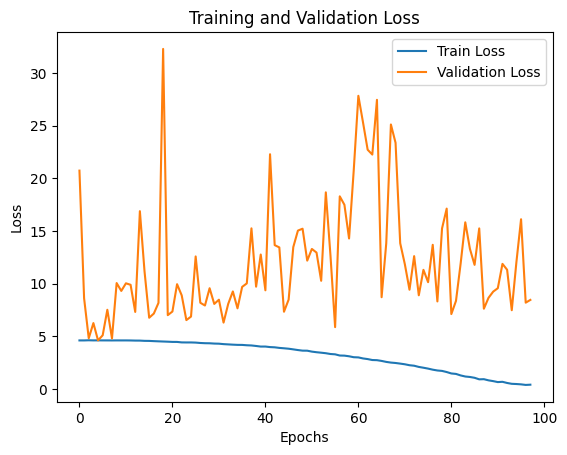

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()